In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')
from odcd.metrics import DataTracker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [2]:
import numpy as np
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Model
from keras.utils import to_categorical

In [3]:
import numpy as np
from skmultiflow.drift_detection.adwin import ADWIN

In [4]:
import streaming_sim_test as sst

In [5]:
from importlib import reload

In [6]:
from sklearn.neighbors import NearestNeighbors

In [7]:
import colorama
from colorama import Fore, Style

In [12]:
def prepare_data_mnist(permute=False, perm_features=50, fashion=False):
    
    if fashion:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

    # define train and test set
    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    print('x_train shape:', X_train.shape, 'x_test shape:', X_test.shape)
    
    if not permute:
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
    
    
        return None, None, X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    else:
        mapp = {(28 * i) + j: [i, j]  for i in range(28) for j in range(28)}
        perm_1 = np.random.permutation(range(28 * 28))[:perm_features]
        perm_2 = np.random.permutation(range(28 * 28))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return None, None, X_train, y_train, X_test, y_test, X_cd, y_cd
        
def prepare_data_wines(path_white='/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv',
                     path_red='/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv',
                     binary_target=True, scale=True, permute=True, perm_features=5):
    
    df_white = pd.read_csv(path_white)
    df_white['quality'].value_counts() / len(df_white)
    
    if binary_target:
        df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_white['target'] = df_white['quality']
    df_white.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('White distribution', df_white[target].value_counts() / len(df_white))
    
    features = [col for col in df_white.columns if col != target]
    X, y = df_white[features].values, df_white[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
    y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)
    
    df_red = pd.read_csv(path_red)
    df_red['quality'].value_counts() / len(df_red)
    
    if binary_target:
        df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_red['target'] = df_red['quality']
    df_red.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('Red distribution ', df_red[target].value_counts() / len(df_red))
    
    features = [col for col in df_red.columns if col != target]
    X_red, y_red = df_red[features].values, df_red[target].values
    if scale:
        X_red = scaler.transform(X_red)
    
    y_red = tf.keras.utils.to_categorical(y_red)
    y_red = np.delete(y_red, np.where(~y_red.any(axis=0)), axis=1)
    
    if not permute:
        return df_white, df_red, X_train, y_train, X_test, y_test, X_red, y_red 
    else:
        perm_1 = np.random.permutation(range(11))[:perm_features]
        perm_2 = np.random.permutation(range(11))[:perm_features]
        
        X_cd = X_test.copy()
        X_cd[:, perm_1] = X_cd[:, perm_2]
        
        y_cd = y_test
        return df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd 
        

In [13]:
# define and  train an cnn model
def model_mnist(nb_classes=10):
    x_in = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x_out = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)

    cnn = tf.keras.models.Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

def model_wines(binary_target=True):
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(100, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

In [14]:
def evaluate(clf, X, y):
    y_preds = clf.predict(X)
    y_preds = np.argmax(y_preds, axis=1)
    y = np.argmax(y, axis=1)
    print('Accuracy:', accuracy_score(y_preds, y))
    print('Confusion matrix:', confusion_matrix(y_preds, y))

In [15]:
def make_data_stream(signal, agg='mean', window = 100):
    if agg == 'window':
        data_stream = []
        for i in range(len(signal)):
            data_stream.append(signal[i:i + window].mean())
        data_stream = np.asarray(data_stream)
        df = pd.Series(data_stream, name='stream').to_frame().reset_index()

    elif agg == 'mean':
        data_stream = np.zeros(len(signal) - start)
        mu = Mean()
        var = Var()
        for i in range(len(data_stream)):
            mu.update(signal[i + start])
            data_stream[i] = mu.get()
        df = pd.DataFrame()
        df['stream_raw'] = signal
        df['stream'] = data_stream
        df.reset_index(inplace=True)

    elif agg == 'raw':
        data_stream = signal
        df = pd.Series(data_stream, name='stream').to_frame().reset_index()
    return df

# Mnist

### Prepare data

In [30]:
_, _, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_mnist(permute=True, perm_features=50)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


### Train model

In [31]:
clf = model_mnist()

In [32]:
train = True
if train:
    clf.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))
else:
    clf = tf.keras.models.load_model('cnn.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 46s 766us/sample - loss: 0.2768 - acc: 0.9125 - val_loss: 0.0657 - val_acc: 0.9803
Epoch 2/2
60000/60000 [==============================] - 50s 839us/sample - loss: 0.1161 - acc: 0.9635 - val_loss: 0.0498 - val_acc: 0.9836


### Evaluate model

In [36]:
print('Train white')
evaluate(clf, X_train, y_train)

Train white
Accuracy: 0.98585
Confusion matrix: [[5885    1    0    1    2    3    6    2    8   10]
 [   1 6669    8    0    7    1    3    8    9    5]
 [  14   30 5895   18    8    5    2   29   19    7]
 [   3    8   22 6069    0   47    1    5   26   23]
 [   1    4    4    0 5734    1    3   11   14    8]
 [   3    0    0    7    0 5312   21    1   13    7]
 [   7    3    0    0    7   18 5866    0   10    1]
 [   0   18   19   16    3    0    0 6174    9   31]
 [   4    8    8    8    4   16   16    5 5699    9]
 [   5    1    2   12   77   18    0   30   44 5848]]


In [37]:
print('Test white')
evaluate(clf, X_test, y_test)

Test white
Accuracy: 0.9836
Confusion matrix: [[ 973    0    0    0    0    1    5    1    5    3]
 [   0 1127    0    0    0    0    2    1    0    4]
 [   4    4 1019    1    1    1    0   11    4    1]
 [   0    2    4 1001    0    8    0    1    4    5]
 [   0    0    0    0  962    0    2    0    3    3]
 [   0    1    0    4    0  874    4    0    2    3]
 [   1    0    0    0    1    2  941    0    0    0]
 [   1    0    5    3    0    1    0 1005    2    2]
 [   1    1    4    1    2    2    4    1  948    2]
 [   0    0    0    0   16    3    0    8    6  986]]


In [38]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.9694
Confusion matrix: [[ 962    0    0    0    0    0    4    1    3    2]
 [   0 1120    1    0    0    0    5    3    0    3]
 [   7    3 1019    2    3    1    0   11    8    0]
 [   4    5    7 1005    2   31   17    3   35   11]
 [   0    0    0    0  957    0    4    1    1    2]
 [   4    1    0    1    0  854   28    1    8    3]
 [   2    1    0    0    0    1  896    0    0    0]
 [   0    0    4    2    0    1    0  998    6    7]
 [   1    3    1    0    2    1    4    1  904    2]
 [   0    2    0    0   18    3    0    9    9  979]]


### Train symmetry finder

In [39]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(28, 28, 1), output_shape=(10, ), intermediate_dim=256, latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      reshape[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            2056        dense_6[0][0]                    
__________________________________________________________________________________________________
z_log_

In [ ]:
vae.fit(X_train, x_test=X_test, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 45s 754us/sample - loss: 0.3917 - val_loss: 0.1044
Epoch 2/10
60000/60000 [==============================] - 55s 913us/sample - loss: 0.1783 - val_loss: 0.0803
Epoch 3/10
60000/60000 [==============================] - 48s 798us/sample - loss: 0.1542 - val_loss: 0.0773
Epoch 4/10
60000/60000 [==============================] - 44s 736us/sample - loss: 0.1420 - val_loss: 0.0615
Epoch 5/10
60000/60000 [==============================] - 49s 822us/sample - loss: 0.1333 - val_loss: 0.0589
Epoch 6/10
14336/60000 [======>.......................] - ETA: 39s - loss: 0.1230

### Prepare stream signals

In [533]:
_, _, _, _, _, _, X_cd, y_cd = prepare_data_mnist(permute=True, perm_features=50)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


Sample instance from the MNIST data set.


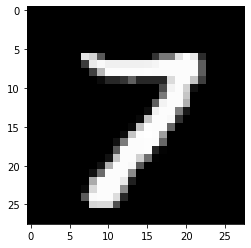

In [534]:
idx = 34
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


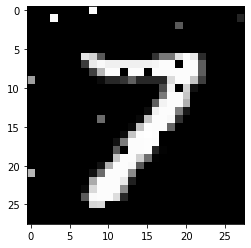

In [535]:
x = X_cd[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [536]:
print('test')
evaluate(clf, X_test, y_test)

test
Accuracy: 0.9867
Confusion matrix: [[ 976    0    2    0    1    1    7    1    3    2]
 [   0 1131    1    0    0    0    3    2    0    3]
 [   1    2 1016    2    2    1    0    8    2    0]
 [   0    2    4 1002    0    4    1    2    3    3]
 [   0    0    1    0  974    0    2    0    3    8]
 [   0    0    0    4    0  884    3    1    3    5]
 [   1    0    0    0    1    1  938    0    0    0]
 [   1    0    5    1    0    0    0 1011    1    4]
 [   1    0    3    1    0    1    4    1  951    0]
 [   0    0    0    0    4    0    0    2    8  984]]


In [537]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.9729
Confusion matrix: [[ 963    0    0    0    0    0    4    0    2    2]
 [   0 1126    2    0    2    0    4    3    0    2]
 [   3    4 1005    1    4    1    2    8    3    2]
 [   3    3   20 1005    0   17   11    4   27    7]
 [   0    0    0    0  965    0    5    0    3    6]
 [   6    1    0    2    0  874   30    1   17    7]
 [   2    1    0    0    1    0  899    0    0    0]
 [   0    0    4    0    0    0    0 1006    1    5]
 [   3    0    0    1    0    0    3    1  908    0]
 [   0    0    1    1   10    0    0    5   13  978]]


In [538]:
# Symmetry signal
symm_samples_train, orig_preds_train, trans_preds_train = vae.vae.predict(X_train)
symm_samples_test, orig_preds_test, trans_preds_test = vae.vae.predict(X_test)
symm_samples_cd, orig_preds_cd, trans_preds_cd = vae.vae.predict(X_cd)

amp = 1
kl_train = amp * entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = amp * entropy(orig_preds_test.T, trans_preds_test.T)
kl_cd = amp * entropy(orig_preds_cd.T, trans_preds_cd.T)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((np.random.permutation(kl_test), np.random.permutation(kl_cd)))
#kl_concat = kl_test
kl_concat.shape

(20000,)

In [539]:
fit_NNS = False
if fit_NNS:
    neigh = NearestNeighbors(1)
    neigh.fit(X_train_flat)

In [ ]:
# Distance signal
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_cd_flat = X_cd.reshape(X_cd.shape[0], -1)
    
d_train = neigh.kneighbors(X_train_flat, return_distance=True)[0].flatten()
d_test = neigh.kneighbors(X_test_flat, return_distance=True)[0].flatten()
d_cd = neigh.kneighbors(X_cd_flat, return_distance=True)[0].flatten()

baseline_std_plus = d_train.mean() + d_train.std()
baseline_std_minus = d_train.mean() - d_train.std()

d_concat = np.concatenate((np.random.permutation(d_test), np.random.permutation(d_cd)))
#kl_concat = kl_test
d_concat.shape

### Analyse signals

In [ ]:
#agg = 'mean', 'window' or 'raw'

# distance metric signal
#df = make_data_stream(d_concat, agg='mean')
# kl signal
df = make_data_stream(d_test, agg='mean')

In [ ]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [ ]:
adwin = ADWIN(delta=0.0002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < 10000:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

In [ ]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

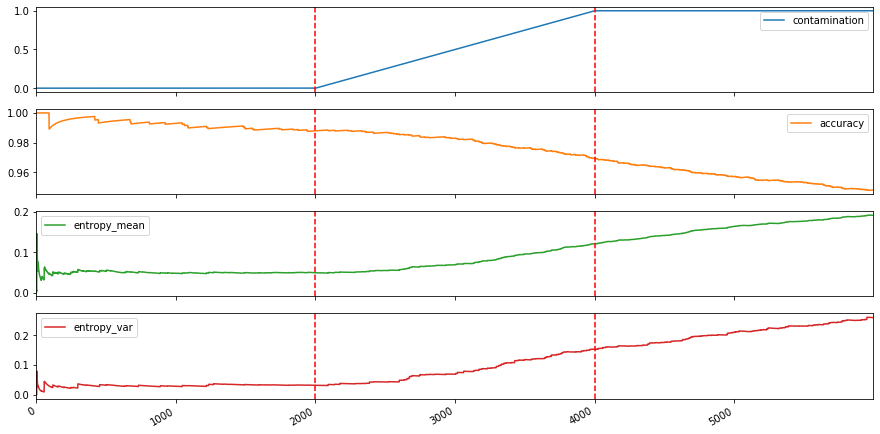

In [529]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

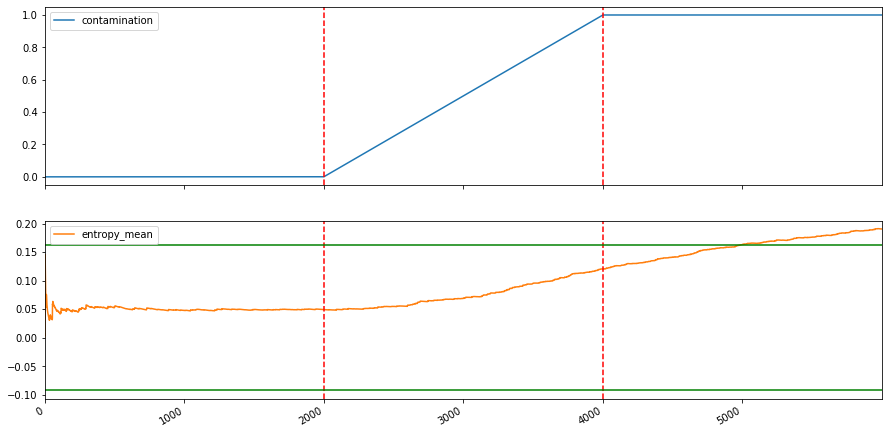

In [530]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [531]:
df

,rw,entropy,pred_prob,accuracy,contamination,entropy_mean,entropy_var
0,1,0.000491,[0.9992256],1.000000,0.0,0.000491,0.000000
1,1,0.012219,[0.99921024],1.000000,0.0,0.006355,0.000069
2,1,0.000133,[0.99978954],1.000000,0.0,0.004281,0.000047
3,1,0.569351,[0.98436326],1.000000,0.0,0.145549,0.079858
4,1,0.052294,[0.98343116],1.000000,0.0,0.126898,0.061632
...,...,...,...,...,...,...,...
5995,1,0.047921,[0.98567724],0.948132,1.0,0.190618,0.260141
5996,1,0.010765,[0.9999789],0.948141,1.0,0.190588,0.260103
5997,1,0.003274,[0.9959187],0.948149,1.0,0.190557,0.260066
5998,1,0.056980,[0.95056254],0.948158,1.0,0.190534,0.260025


In [532]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.02)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.07481556552662218 - at index: 3167
Change detected in data: 0.08414855754892916 - at index: 3327
Change detected in data: 0.09333241963265522 - at index: 3455
Change detected in data: 0.09802862946529645 - at index: 3583
Change detected in data: 0.11316805863297309 - at index: 3839
Change detected in data: 0.1220982221838251 - at index: 4031
Change detected in data: 0.12625496670592576 - at index: 4095
Change detected in data: 0.1305944293447754 - at index: 4255
Change detected in data: 0.13871433648720385 - at index: 4415
Change detected in data: 0.14526548599592273 - at index: 4607
Change detected in data: 0.15408780193323363 - at index: 4735
Change detected in data: 0.15858678983899288 - at index: 4895
Change detected in data: 0.1642752112770254 - at index: 5023
Change detected in data: 0.16867114749378698 - at index: 5183
Change detected in data: 0.1706835459544482 - at index: 5311
Change detected in data: 0.17576159468094946 - at index: 5471
Change detec

# Wines

### Prepare data

In [472]:
# Wines
df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_wines(permute=True, perm_features=3)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


### Train model

In [473]:
# wines
clf = model_wines()

In [474]:
#wines 
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 37s 625us/sample - loss: 0.2680 - acc: 0.9146 - val_loss: 0.0562 - val_acc: 0.9811
Epoch 2/2
60000/60000 [==============================] - 41s 692us/sample - loss: 0.1065 - acc: 0.9671 - val_loss: 0.0439 - val_acc: 0.9867


### Evaluate model

In [475]:
print('Train white')
evaluate(clf, X_train, y_train)

Train white
Accuracy: 0.9871333333333333
Confusion matrix: [[5887    1    0    1    2    2    8    1    3    9]
 [   3 6702    6    2   11    1   10   16   22    7]
 [   4   20 5893   16    5    3    3   24    9    5]
 [   3    2   21 6060    1   20    1   12   22    6]
 [   1    1    7    0 5782    2   11    8   13   50]
 [   5    0    0   19    1 5363   21    4   16   20]
 [  10    4    0    0    3   16 5846    0    8    1]
 [   0    9   16   14    4    0    0 6174    2   41]
 [   5    3   12    9    1   10   18    3 5724   13]
 [   5    0    3   10   32    4    0   23   32 5797]]


In [476]:
print('Test white')
evaluate(clf, X_test, y_test)

Test white
Accuracy: 0.9867
Confusion matrix: [[ 976    0    2    0    1    1    7    1    3    2]
 [   0 1131    1    0    0    0    3    2    0    3]
 [   1    2 1016    2    2    1    0    8    2    0]
 [   0    2    4 1002    0    4    1    2    3    3]
 [   0    0    1    0  974    0    2    0    3    8]
 [   0    0    0    4    0  884    3    1    3    5]
 [   1    0    0    0    1    1  938    0    0    0]
 [   1    0    5    1    0    0    0 1011    1    4]
 [   1    0    3    1    0    1    4    1  951    0]
 [   0    0    0    0    4    0    0    2    8  984]]


In [477]:
print((X_cd == X_test).all())

False


In [478]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.9799
Confusion matrix: [[ 973    0    0    0    1    0    5    0    2    2]
 [   0 1128    1    0    1    0    4    4    0    4]
 [   2    3 1016    2    2    0    1    9    3    1]
 [   1    3    9 1002    0   17    3    3   21    6]
 [   0    0    1    0  970    0    4    0    3    9]
 [   2    0    0    3    0  874   13    1    8    6]
 [   1    1    0    0    1    1  926    0    0    0]
 [   0    0    5    1    0    0    0 1008    2    5]
 [   1    0    0    1    0    0    2    1  926    0]
 [   0    0    0    1    7    0    0    2    9  976]]


### Train symmetry finder

In [479]:
# wines
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11, ), output_shape=(2, ), intermediate_dim=256, latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          200960      reshape_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            2056        dense_12[0][0]                   
__________________________________________________________________________________________________
z_log_

In [480]:
vae.fit(X_train, x_test=X_test, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 42s 699us/sample - loss: 0.4162 - val_loss: 0.1184
Epoch 2/10
60000/60000 [==============================] - 41s 677us/sample - loss: 0.1769 - val_loss: 0.0947
Epoch 3/10
60000/60000 [==============================] - 42s 705us/sample - loss: 0.1496 - val_loss: 0.0769
Epoch 4/10
60000/60000 [==============================] - 42s 707us/sample - loss: 0.1387 - val_loss: 0.0660
Epoch 5/10
60000/60000 [==============================] - 42s 693us/sample - loss: 0.1310 - val_loss: 0.0599
Epoch 6/10
60000/60000 [==============================] - 42s 694us/sample - loss: 0.1249 - val_loss: 0.0527
Epoch 7/10
60000/60000 [==============================] - 45s 752us/sample - loss: 0.1211 - val_loss: 0.0602
Epoch 8/10
60000/60000 [==============================] - 43s 719us/sample - loss: 0.1172 - val_loss: 0.0566
Epoch 9/10
60000/60000 [==============================] - 43s 722us/sample - l

### stream

In [481]:
df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_wines(permute=True, perm_features=3)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


In [484]:
print('test')
evaluate(clf, X_test, y_test)

test
Accuracy: 0.9867
Confusion matrix: [[ 976    0    2    0    1    1    7    1    3    2]
 [   0 1131    1    0    0    0    3    2    0    3]
 [   1    2 1016    2    2    1    0    8    2    0]
 [   0    2    4 1002    0    4    1    2    3    3]
 [   0    0    1    0  974    0    2    0    3    8]
 [   0    0    0    4    0  884    3    1    3    5]
 [   1    0    0    0    1    1  938    0    0    0]
 [   1    0    5    1    0    0    0 1011    1    4]
 [   1    0    3    1    0    1    4    1  951    0]
 [   0    0    0    0    4    0    0    2    8  984]]


In [485]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.9064
Confusion matrix: [[879   0   0   0   0   0   3   0   0   2]
 [  0 920   1   0   0   0   2   3   0   3]
 [  9  33 964   1   9   0   5   6   5   5]
 [ 13  47  60 989   3  10  13  43  46  13]
 [  0   2   1   0 933   0   4   1   4   4]
 [ 72  37   1  19  10 881  79   6 136  42]
 [  3   5   0   0   2   1 850   0   0   0]
 [  1  48   4   1   1   0   0 946   2   6]
 [  3  40   1   0   1   0   2   0 768   0]
 [  0   3   0   0  23   0   0  23  13 934]]


In [486]:
# Symmetry signal
symm_samples_train, orig_preds_train, trans_preds_train = vae.vae.predict(X_train)
symm_samples_test, orig_preds_test, trans_preds_test = vae.vae.predict(X_test)
symm_samples_cd, orig_preds_cd, trans_preds_cd = vae.vae.predict(X_cd)

amp = 1
kl_train = amp * entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = amp * entropy(orig_preds_test.T, trans_preds_test.T)
kl_cd = amp * entropy(orig_preds_cd.T, trans_preds_cd.T)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((np.random.permutation(kl_test), np.random.permutation(kl_cd)))
#kl_concat = kl_test
kl_concat.shape

(20000,)

In [ ]:
# Distance signal
if len(X_train.shape[1:]) > 1:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_cd = X_cd.reshape(X_cd.shape[0], -1)
    
neigh = NearestNeighbors(1)
neigh.fit(X_train)
    
d_train = neigh.kneighbors(X_train, return_distance=True)[0].flatten()
d_test = neigh.kneighbors(X_test, return_distance=True)[0].flatten()
d_cd = neigh.kneighbors(X_cd, return_distance=True)[0].flatten()

baseline_std_plus = d_train.mean() + d_train.std()
baseline_std_minus = d_train.mean() - d_train.std()

d_concat = np.concatenate((np.random.permutation(d_test), np.random.permutation(d_cd)))
#kl_concat = kl_test
d_concat.shape

In [470]:
#agg = 'mean', 'window' or 'raw'
df = make_data_stream(d_concat, agg='mean')

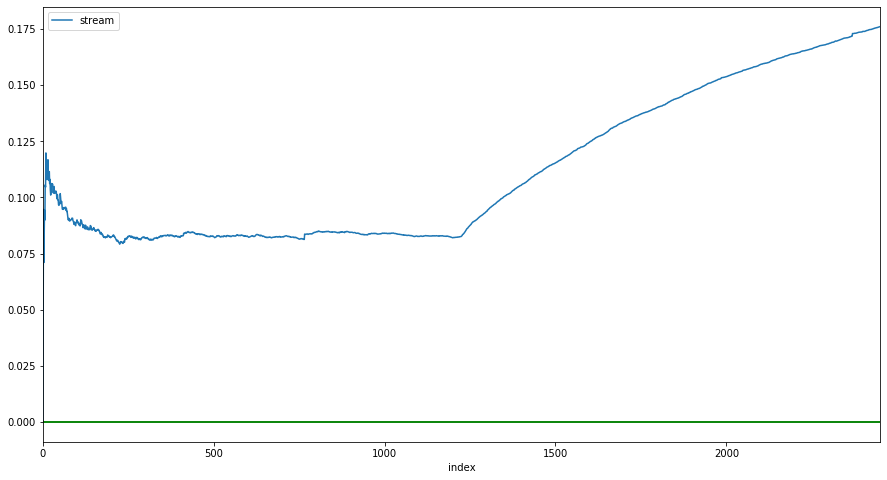

In [471]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [464]:
adwin = ADWIN(delta=0.02)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < 10000:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

In [427]:
cd_start = 100
cd_full = int(1.5 * cd_start)
nb_samples_tot = 2000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

Sample 0 of 2000
Sample 1000 of 2000


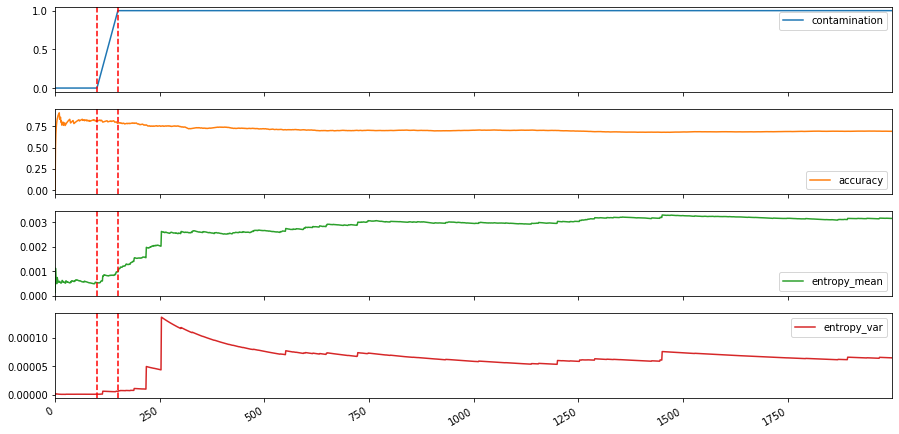

In [428]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

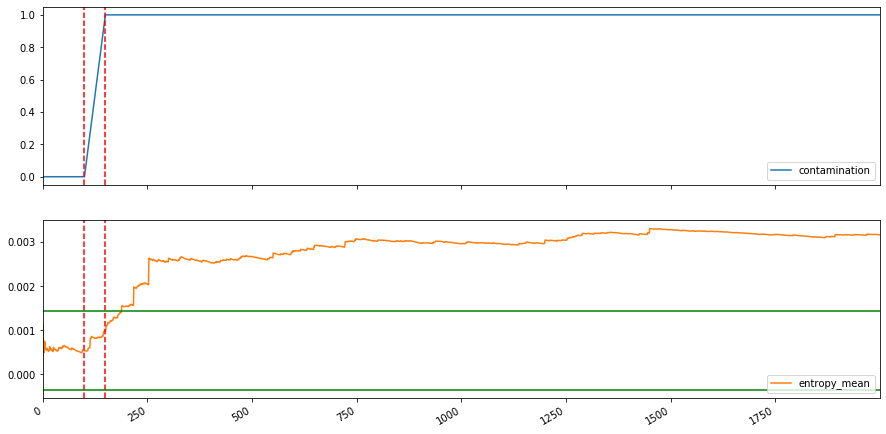

In [429]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [430]:
df

,rw,entropy,pred_prob,accuracy,contamination,entropy_mean,entropy_var
0,0,1.340085e-04,[0.76568115],0.000000,0.0,0.000134,0.000000e+00
1,1,2.116309e-03,[0.8627745],0.500000,0.0,0.001125,1.964759e-06
2,1,1.091580e-05,[0.59948605],0.666667,0.0,0.000754,1.396225e-06
3,1,1.936597e-04,[0.9536984],0.750000,0.0,0.000614,1.009241e-06
4,1,1.984008e-07,[0.58847547],0.800000,0.0,0.000491,8.322130e-07
...,...,...,...,...,...,...,...
1995,1,1.888212e-03,[0.7685955],0.692385,1.0,0.003169,6.460522e-05
1996,1,8.110236e-05,[0.8360774],0.692539,1.0,0.003167,6.457763e-05
1997,0,1.028071e-03,[0.9583167],0.692192,1.0,0.003166,6.454758e-05
1998,1,3.531314e-03,[0.9640252],0.692346,1.0,0.003166,6.451534e-05


In [431]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.02)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))